In [1]:
import os
import sys
import yaml
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import your preprocessing and ridge regression utilities
from preprocessing import make_delayed
from ridge_utils.ridge import bootstrap_ridge, ridge_corr_pred, zs

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path adjustments if needed
sys.path.append("..")  # Adjust if ridge_utils is one level up


In [2]:
# Load pre-saved embeddings
train_embeddings = torch.load("train_embeddings.pt").cpu().numpy()
test_embeddings = torch.load("test_embeddings.pt").cpu().numpy()

# Load wordseq metadata
with open("/ocean/projects/mth240012p/shared/data/raw_text.pkl", "rb") as f:
    raw_text = pickle.load(f)

# Match story names to embeddings
story_keys = list(raw_text.keys())

train_story_names = [story_keys[i] for i in range(len(train_embeddings))]
test_story_names = [story_keys[i] for i in range(len(test_embeddings))]

# Build lookup
train_vecs = {s: train_embeddings[i] for i, s in enumerate(train_story_names)}
test_vecs  = {s: test_embeddings[i] for i, s in enumerate(test_story_names)}


In [3]:
from preprocessing import lanczosinterp2D

def downsample_embeddings(stories, vectors, wordseqs):
    downsampled = {}
    for story in stories:
        vec = vectors[story]
        if len(wordseqs[story].data_times) != vec.shape[0]:
            story_duration = wordseqs[story].tr_times[-1]
            wordseqs[story].data_times = np.linspace(0, story_duration, vec.shape[0])
        downsampled[story] = lanczosinterp2D(
            vec, wordseqs[story].data_times, wordseqs[story].tr_times, window=3
        )
    return downsampled

# Downsample to fMRI TR resolution
wordseqs_train = {s: raw_text[s] for s in train_story_names}
wordseqs_test = {s: raw_text[s] for s in test_story_names}

downsampled_train = downsample_embeddings(train_story_names, train_vecs, wordseqs_train)
downsampled_test = downsample_embeddings(test_story_names, test_vecs, wordseqs_test)

# Create lagged features
delays = [1, 2, 3, 4]
trim_front, trim_back = 5, 10

def trim_and_delay(d):
    return {k: make_delayed(v[trim_front:-trim_back], delays) for k, v in d.items()}

delayed_train = trim_and_delay(downsampled_train)
delayed_test = trim_and_delay(downsampled_test)


/jet/home/jsu4/lab3/preprocessing.py:41: RuntimeWarning: invalid value encountered in divide
  val = window * np.sin(np.pi*t) * np.sin(np.pi*t/window) / (np.pi**2 * t**2)



 Evaluating subject2 with all voxels...
Shapes — X_train: (28298, 512), Y_train: (28298, 94251)
Running bootstrap_ridge... (RAM: 9.0%)


/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]



Results for subject2 — Encoder Embeddings:
Mean CC:    0.0357
Median CC:  0.0350
Top 1% CC:  0.0801
Top 5% CC:  0.0651


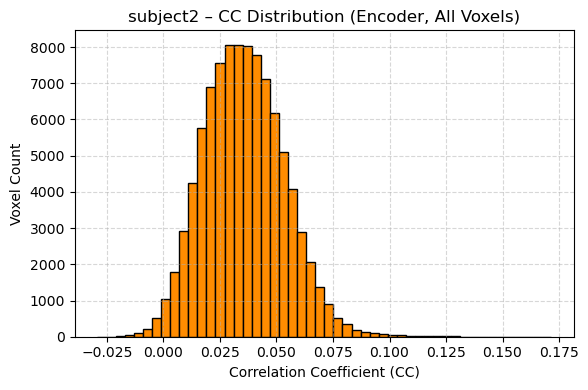

RAM after cleanup: 4.6%

 Evaluating subject3 with all voxels...
Shapes — X_train: (28298, 512), Y_train: (28298, 95556)
Running bootstrap_ridge... (RAM: 10.3%)

Results for subject3 — Encoder Embeddings:
Mean CC:    0.0421
Median CC:  0.0411
Top 1% CC:  0.0970
Top 5% CC:  0.0734


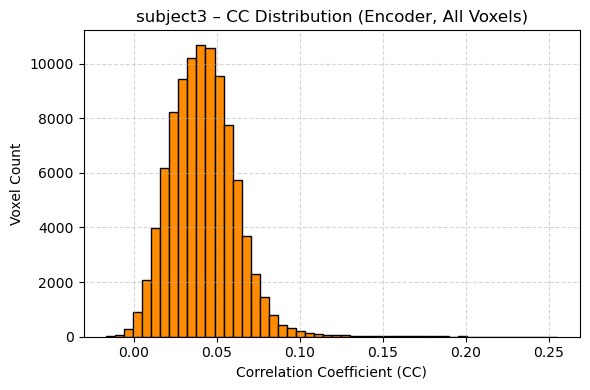

RAM after cleanup: 5.3%


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gc
import psutil
from ridge_utils.ridge import bootstrap_ridge, zs

subject_dirs = {
    "subject2": "/ocean/projects/mth240012p/shared/data/subject2",
    "subject3": "/ocean/projects/mth240012p/shared/data/subject3"
}

alphas = np.logspace(0, 3, 5)
nboots, chunklen, nchunks = 15, 10, 10

for subject, path in subject_dirs.items():
    print(f"\n Evaluating {subject} with all voxels...")

    # Step 1: Collect data
    X_train, Y_train = [], []
    X_test, Y_test = [], []

    for sname, X in delayed_train.items():
        y_path = os.path.join(path, f"{sname}.npy")
        if os.path.exists(y_path):
            Y = np.load(y_path, mmap_mode="r")  # avoid full RAM load initially
            if X.shape[0] == Y.shape[0]:
                X_train.append(X)
                Y_train.append(Y[:])  # force read from disk only if valid

    for sname, X in delayed_test.items():
        y_path = os.path.join(path, f"{sname}.npy")
        if os.path.exists(y_path):
            Y = np.load(y_path, mmap_mode="r")
            if X.shape[0] == Y.shape[0]:
                X_test.append(X)
                Y_test.append(Y[:])

    if not X_train or not X_test:
        print(f"Skipping {subject} — no valid aligned data.")
        continue

    # Step 2: Stack into arrays
    X_train = np.concatenate(X_train, axis=0).astype(np.float32)
    Y_train = np.concatenate(Y_train, axis=0).astype(np.float32)
    X_test  = np.concatenate(X_test, axis=0).astype(np.float32)
    Y_test  = np.concatenate(Y_test, axis=0).astype(np.float32)

    print(f"Shapes — X_train: {X_train.shape}, Y_train: {Y_train.shape}")

    # Step 3: Z-score (inline)
    X_mean, X_std = X_train.mean(0), X_train.std(0)
    Y_mean, Y_std = Y_train.mean(0), Y_train.std(0)

    X_train_z = (X_train - X_mean) / X_std
    Y_train_z = (Y_train - Y_mean) / Y_std
    X_test_z = (X_test - X_mean) / X_std
    Y_test_z = (Y_test - Y_mean) / Y_std

    del X_train, X_test, Y_train, Y_test
    gc.collect()

    print(f"Running bootstrap_ridge... (RAM: {psutil.virtual_memory().percent:.1f}%)")

    # Step 4: Fit bootstrap ridge
    wt, corrs, valphas, *_ = bootstrap_ridge(
        X_train_z, Y_train_z, X_test_z, Y_test_z,
        alphas=alphas,
        nboots=nboots,
        chunklen=chunklen,
        nchunks=nchunks,
        single_alpha=False,
        use_corr=True
    )

    np.save(f"valphas_{subject}_encoder.npy", valphas)

    # Step 5: Report + Plot
    print(f"\nResults for {subject} — Encoder Embeddings:")
    print(f"Mean CC:    {np.mean(corrs):.4f}")
    print(f"Median CC:  {np.median(corrs):.4f}")
    print(f"Top 1% CC:  {np.percentile(corrs, 99):.4f}")
    print(f"Top 5% CC:  {np.percentile(corrs, 95):.4f}")

    plt.figure(figsize=(6, 4))
    plt.hist(corrs, bins=50, color="darkorange", edgecolor="black")
    plt.title(f"{subject} – CC Distribution (Encoder, All Voxels)")
    plt.xlabel("Correlation Coefficient (CC)")
    plt.ylabel("Voxel Count")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Step 6: Memory cleanup
    del X_train_z, Y_train_z, X_test_z, Y_test_z
    del wt, corrs, valphas
    gc.collect()
    print(f"RAM after cleanup: {psutil.virtual_memory().percent:.1f}%")



 Stability Analysis for subject2

 Evaluating 1000 voxels
Mean CC: 0.0368
Median:  0.0357
Top 1%:  0.0785
Top 5%:  0.0665

 Evaluating 10000 voxels
Mean CC: 0.0358
Median:  0.0348
Top 1%:  0.0812
Top 5%:  0.0653

 Evaluating 20000 voxels
 Dropped 2 near-zero variance voxels
Mean CC: 0.0357
Median:  0.0348
Top 1%:  0.0807
Top 5%:  0.0656


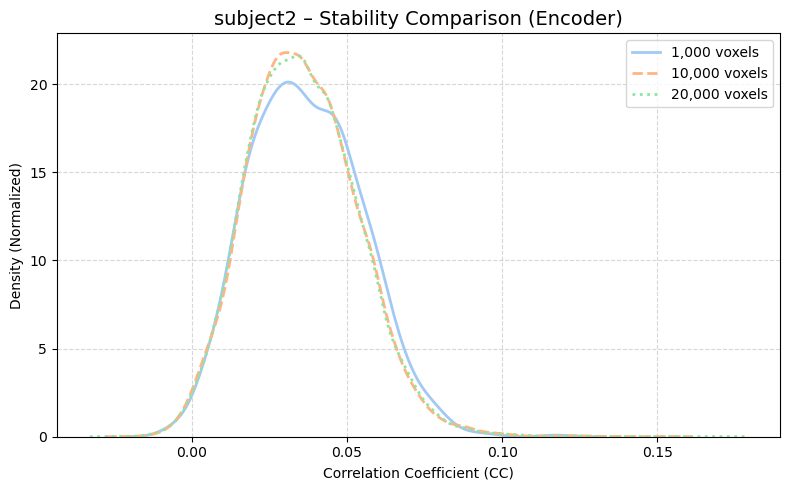


 Stability Analysis for subject3

 Evaluating 1000 voxels
Mean CC: 0.0426
Median:  0.0418
Top 1%:  0.0959
Top 5%:  0.0736

 Evaluating 10000 voxels
Mean CC: 0.0423
Median:  0.0413
Top 1%:  0.1004
Top 5%:  0.0736

 Evaluating 20000 voxels
Mean CC: 0.0421
Median:  0.0412
Top 1%:  0.0976
Top 5%:  0.0734


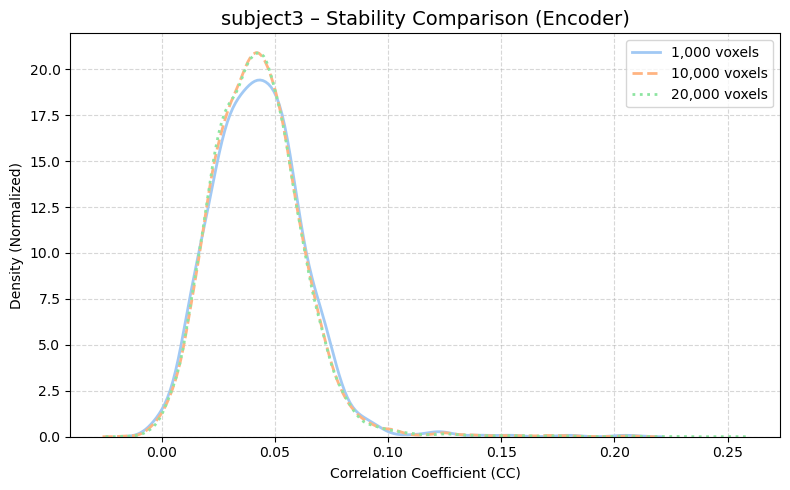

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from ridge_utils.ridge import ridge_corr_pred, zs

subject_dirs = {
    "subject2": "/ocean/projects/mth240012p/shared/data/subject2",
    "subject3": "/ocean/projects/mth240012p/shared/data/subject3"
}

subset_sizes = [1000, 10000, 20000]

custom_colors = {
    1000: "#a1c9f4",
    10000: "#ffb482",
    20000: "#8de5a1"
}

custom_linestyles = {
    1000: "solid",
    10000: "dashed",
    20000: "dotted"
}

for subject in ["subject2", "subject3"]:
    print(f"\n Stability Analysis for {subject}")

    valphas_path = f"valphas_{subject}_encoder.npy"
    valphas = np.load(valphas_path)

    # Rebuild train/test matrices
    X_train, Y_train = [], []
    X_test, Y_test = [], []

    for sname, X in delayed_train.items():
        y_path = os.path.join(subject_dirs[subject], f"{sname}.npy")
        if os.path.exists(y_path):
            Y = np.load(y_path)
            if X.shape[0] == Y.shape[0]:
                X_train.append(X)
                Y_train.append(Y[:])

    for sname, X in delayed_test.items():
        y_path = os.path.join(subject_dirs[subject], f"{sname}.npy")
        if os.path.exists(y_path):
            Y = np.load(y_path)
            if X.shape[0] == Y.shape[0]:
                X_test.append(X)
                Y_test.append(Y[:])

    X_train = np.concatenate(X_train, axis=0).astype(np.float32)
    Y_train = np.concatenate(Y_train, axis=0).astype(np.float32)
    X_test = np.concatenate(X_test, axis=0).astype(np.float32)
    Y_test = np.concatenate(Y_test, axis=0).astype(np.float32)

    # Z-score
    X_train_z = zs(X_train)
    Y_train_z = zs(Y_train)
    X_test_z = (X_test - X_train.mean(0)) / X_train.std(0)
    Y_test_z = (Y_test - Y_train.mean(0)) / Y_train.std(0)

    # Plot setup
    plt.figure(figsize=(8, 5))

    for subset_size in subset_sizes:
        print(f"\n Evaluating {subset_size} voxels")

        np.random.seed(42)
        subset_vox = np.random.choice(Y_train_z.shape[1], subset_size, replace=False)

        Y_train_sub = Y_train_z[:, subset_vox]
        Y_test_sub = Y_test_z[:, subset_vox]
        valphas_sub = valphas[subset_vox]

        # Drop zero-variance voxels
        stds = Y_train_sub.std(0)
        valid = stds > 1e-6
        if not np.all(valid):
            print(f" Dropped {np.sum(~valid)} near-zero variance voxels")
            Y_train_sub = Y_train_sub[:, valid]
            Y_test_sub = Y_test_sub[:, valid]
            valphas_sub = valphas_sub[valid]

        # Ridge prediction
        corrs = ridge_corr_pred(
            X_train_z, X_test_z,
            Y_train_sub, Y_test_sub,
            valphas=valphas_sub,
            normalpha=False,
            use_corr=True
        )

        # Report
        print(f"Mean CC: {np.nanmean(corrs):.4f}")
        print(f"Median:  {np.nanmedian(corrs):.4f}")
        print(f"Top 1%:  {np.nanpercentile(corrs, 99):.4f}")
        print(f"Top 5%:  {np.nanpercentile(corrs, 95):.4f}")

        # KDE plot
        sns.kdeplot(
            corrs[~np.isnan(corrs)],
            label=f"{subset_size:,} voxels",
            color=custom_colors[subset_size],
            linestyle=custom_linestyles[subset_size],
            linewidth=2,
            fill=False
        )

    plt.title(f"{subject} – Stability Comparison (Encoder)", fontsize=14)
    plt.xlabel("Correlation Coefficient (CC)")
    plt.ylabel("Density (Normalized)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Cleanup
    del X_train, Y_train, X_test, Y_test
    del X_train_z, Y_train_z, X_test_z, Y_test_z
    gc.collect()
